In [2]:
# cell 1
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from textblob import TextBlob  # for sentiment analysis

# plotting defaults
plt.rcParams['figure.figsize'] = (12,5)
pd.options.display.max_columns = 200

DATA_DIR = "../yfinance"
data = "../data"


In [3]:
tickers = ["AAPL","AMZN","GOOG","MSFT","META","NVDA"]
prices = {}

for symbol in tickers:
    file_path_csv = os.path.join(DATA_DIR, f"{symbol}.csv")
    
    if os.path.exists(file_path_csv):
        # parse 'Date' column and rename to 'date'
        df = pd.read_csv(file_path_csv, parse_dates=['Date'])
        df.rename(columns={'Date':'date'}, inplace=True)
    else:
        raise FileNotFoundError(f"File not found: {file_path_csv}")
    
    # Normalize date to midnight and compute daily returns
    df['date'] = pd.to_datetime(df['date']).dt.normalize()
    df['daily_return'] = df['Close'].pct_change()
    
    prices[symbol] = df

# Check AAPL data
prices['AAPL'].head()


,date,Close,High,Low,Open,Volume,daily_return
0,2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200,NaN
1,2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400,0.042204
2,2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400,-0.016494
3,2009-01-07,2.729484,2.774170,2.706990,2.753477,753048800,-0.021609
4,2009-01-08,2.780169,2.793666,2.700393,2.712090,673500800,0.018570


In [4]:
# cell 3
news = pd.read_csv(os.path.join(data, "news_cleaned.csv"), parse_dates=['date'])
news['date'] = pd.to_datetime(news['date']).dt.normalize()  # align to date only
news.head()


,Unnamed: 0,headline,url,publisher,date,stock,headline_length,day_of_week,hour,publisher_domain
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 00:00:00+00:00,A,39,Friday,14.0,unknown
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 00:00:00+00:00,A,42,Wednesday,14.0,unknown
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 00:00:00+00:00,A,29,Tuesday,8.0,unknown
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 00:00:00+00:00,A,44,Friday,16.0,unknown
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 00:00:00+00:00,A,87,Friday,15.0,unknown


In [5]:
# cell 4
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

news['sentiment'] = news['headline'].apply(get_sentiment)
news.head()
print(news.columns.tolist())

['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock', 'headline_length', 'day_of_week', 'hour', 'publisher_domain', 'sentiment']


In [8]:
print(news.columns.tolist())

daily_sentiment = (
    news.groupby(['stock', 'date'])['sentiment']   # select the column properly
        .mean()
        .reset_index()
        .rename(columns={'sentiment': 'avg_sentiment'})
)

daily_sentiment.head()


['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock', 'headline_length', 'day_of_week', 'hour', 'publisher_domain', 'sentiment']


,stock,date,avg_sentiment
0,A,2020-05-22 00:00:00+00:00,0.035714
1,A,2020-05-26 00:00:00+00:00,0.000000
2,A,2020-06-03 00:00:00+00:00,0.000000
3,A,2020-06-05 00:00:00+00:00,0.000000
4,AA,2020-05-18 00:00:00+00:00,0.062500


In [10]:
# Make both date columns timezone-naive
for symbol in tickers:
    prices[symbol]['date'] = prices[symbol]['date'].dt.tz_localize(None)

# Strip timezone from news as well
daily_sentiment['date'] = daily_sentiment['date'].dt.tz_localize(None)
merged_data = {}
for symbol in tickers:
    df_price = prices[symbol]
    df_sent = daily_sentiment[daily_sentiment['stock'] == symbol]

    merged = pd.merge(df_price, df_sent, on='date', how='left')
    merged['avg_sentiment'] = merged['avg_sentiment'].fillna(0)
    merged_data[symbol] = merged
    print(merged.head())


        date     Close      High       Low      Open      Volume  \
0 2009-01-02  2.721686  2.730385  2.554037  2.575630   746015200   
1 2009-01-05  2.836553  2.884539  2.780469  2.794266  1181608400   
2 2009-01-06  2.789767  2.914229  2.770872  2.877641  1289310400   
3 2009-01-07  2.729484  2.774170  2.706990  2.753477   753048800   
4 2009-01-08  2.780169  2.793666  2.700393  2.712090   673500800   

   daily_return stock  avg_sentiment  
0           NaN   NaN            0.0  
1      0.042204   NaN            0.0  
2     -0.016494   NaN            0.0  
3     -0.021609   NaN            0.0  
4      0.018570   NaN            0.0  
        date  Close    High     Low    Open     Volume  daily_return stock  \
0 2009-01-02  2.718  2.7265  2.5535  2.5675  145928000           NaN   NaN   
1 2009-01-05  2.703  2.7870  2.6515  2.7865  190196000     -0.005519   NaN   
2 2009-01-06  2.868  2.9110  2.6875  2.7275  221602000      0.061043   NaN   
3 2009-01-07  2.810  2.8475  2.7675  2.8145  

In [11]:
# cell 7
for symbol in tickers:
    df = merged_data[symbol]
    corr = df['daily_return'].corr(df['avg_sentiment'])
    print(f"{symbol} | Pearson correlation: {corr:.4f}")


AAPL | Pearson correlation: 0.0323
AMZN | Pearson correlation: 0.0101
GOOG | Pearson correlation: 0.0011
MSFT | Pearson correlation: nan
META | Pearson correlation: nan
NVDA | Pearson correlation: 0.0119


C:\Users\pc\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\pc\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


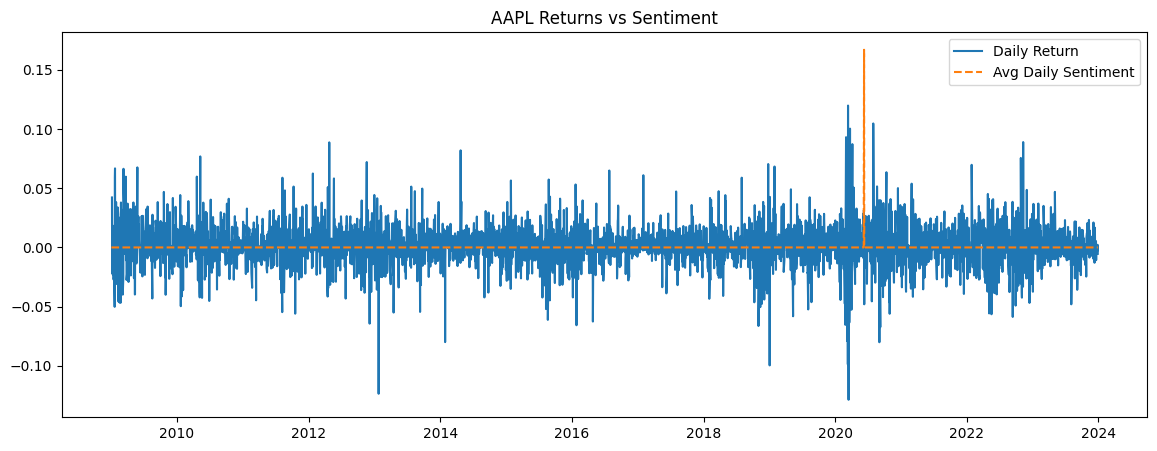

In [12]:
# cell 8a
symbol = "AAPL"
df = merged_data[symbol]

plt.figure(figsize=(14,5))
plt.plot(df['date'], df['daily_return'], label='Daily Return')
plt.plot(df['date'], df['avg_sentiment'], label='Avg Daily Sentiment', linestyle='--')
plt.title(f"{symbol} Returns vs Sentiment")
plt.legend()
plt.show()


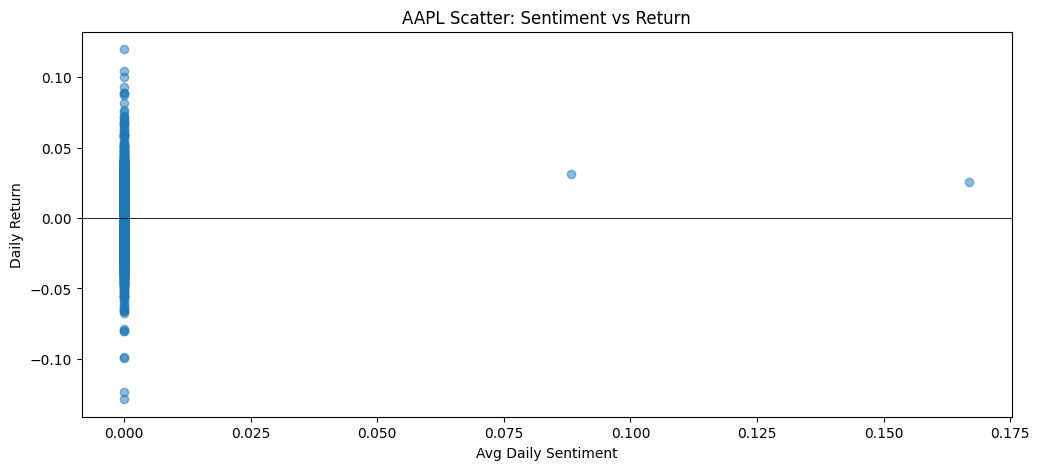

In [13]:
# cell 8b
plt.scatter(df['avg_sentiment'], df['daily_return'], alpha=0.5)
plt.axhline(0, color='k', linewidth=0.6)
plt.xlabel("Avg Daily Sentiment")
plt.ylabel("Daily Return")
plt.title(f"{symbol} Scatter: Sentiment vs Return")
plt.show()
